In [1]:
%matplotlib inline


# Optimizing the Gromov-Wasserstein distance with PyTorch

In this example, we use the pytorch backend to optimize the Gromov-Wasserstein
(GW) loss between two graphs expressed as empirical distribution.

In the first part, we optimize the weights on the node of a simple template
graph so that it minimizes the GW with a given Stochastic Block Model graph.
We can see that this actually recovers the proportion of classes in the SBM
and allows for an accurate clustering of the nodes using the GW optimal plan.

In the second part, we optimize simultaneously the weights and the sructure of
the template graph which allows us to perform graph compression and to recover
other properties of the SBM.

The backend actually uses the gradients expressed in [38] to optimize the
weights.

[38] C. Vincent-Cuaz, T. Vayer, R. Flamary, M. Corneli, N. Courty, Online Graph
Dictionary Learning, International Conference on Machine Learning (ICML), 2021.


In [32]:
from sklearn.manifold import MDS
import numpy as np
import matplotlib.pylab as pl
import torch

import ot
from ot.gromov import gromov_wasserstein2

## Graph generation



nbpc is [50 30 20]
n is 100
C.size is (100, 100)
C1.shape is (100, 100)


/Users/thnguy22/opt/anaconda3/envs/singlecell/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/var/folders/br/tv3_c1y52c7_s76srz9y44xr0000gq/T/ipykernel_90919/1497026418.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmax' will be ignored
  pl.scatter(x[:, 0], x[:, 1], c=color, s=s, zorder=10, edgecolors='k', cmap='tab10', vmax=9)


(-0.5, 99.5, 99.5, -0.5)

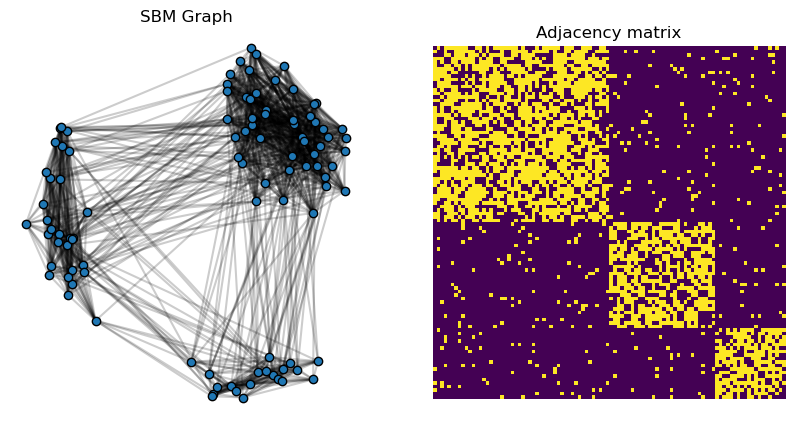

In [43]:
rng = np.random.RandomState(42)


def get_sbm(n, nc, ratio, P):
    nbpc = np.round(n * ratio).astype(int)
    print('nbpc is', nbpc)
    n = np.sum(nbpc)
    print('n is', n)
    C = np.zeros((n, n))
    print('C.size is', C.shape)
    for c1 in range(nc):
        for c2 in range(c1 + 1):
            if c1 == c2:
                for i in range(np.sum(nbpc[:c1]), np.sum(nbpc[:c1 + 1])):
                    for j in range(np.sum(nbpc[:c2]), i):
                        if rng.rand() <= P[c1, c2]:
                            C[i, j] = 1
            else:
                for i in range(np.sum(nbpc[:c1]), np.sum(nbpc[:c1 + 1])):
                    for j in range(np.sum(nbpc[:c2]), np.sum(nbpc[:c2 + 1])):
                        if rng.rand() <= P[c1, c2]:
                            C[i, j] = 1

    return C + C.T


n = 100
nc = 3
ratio = np.array([.5, .3, .2])
P = np.array(0.6 * np.eye(3) + 0.05 * np.ones((3, 3)))
C1 = get_sbm(n, nc, ratio, P)
print('C1.shape is', C1.shape)

# get 2d position for nodes
x1 = MDS(dissimilarity='precomputed', random_state=0).fit_transform(1 - C1)


def plot_graph(x, C, color='C0', s=None):
    for j in range(C.shape[0]):
        for i in range(j):
            if C[i, j] > 0:
                pl.plot([x[i, 0], x[j, 0]], [x[i, 1], x[j, 1]], alpha=0.2, color='k')
    pl.scatter(x[:, 0], x[:, 1], c=color, s=s, zorder=10, edgecolors='k', cmap='tab10', vmax=9)


pl.figure(1, (10, 5))
pl.clf()
pl.subplot(1, 2, 1)
plot_graph(x1, C1, color='C0')
pl.title("SBM Graph")
pl.axis("off")
pl.subplot(1, 2, 2)
pl.imshow(C1, interpolation='nearest')
pl.title("Adjacency matrix")
pl.axis("off")

## Optimizing GW w.r.t. the weights on a template structure
The adajacency matrix C1 is block diagonal with 3 blocks. We want to
optimize the weights of a simple template C0=eye(3) and see if we can
recover the proportion of classes from the SBM (up to a permutation).



(3, 3)
(100, 100)
100
Estimated weights :  [0.3028101  0.20249103 0.49469887]
True proportions :  [0.5 0.3 0.2]


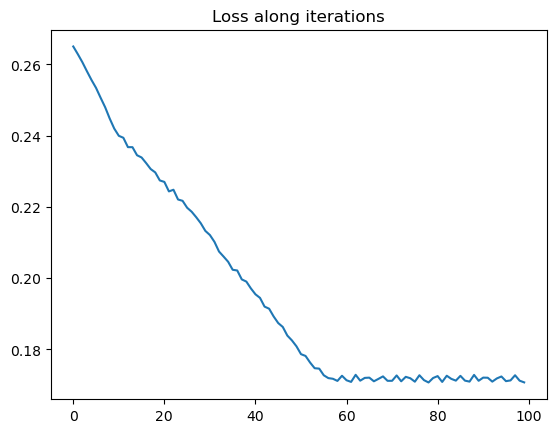

In [44]:
C0 = np.eye(3)


def min_weight_gw(C1, C2, a2, nb_iter_max=100, lr=1e-2):
    """ solve min_a GW(C1,C2,a, a2) by gradient descent"""

    # use pyTorch for our data
    C1_torch = torch.tensor(C1)
    C2_torch = torch.tensor(C2)

    a0 = rng.rand(C1.shape[0])  # random_init
    a0 /= a0.sum()  # on simplex
    a1_torch = torch.tensor(a0).requires_grad_(True)
    a2_torch = torch.tensor(a2)

    loss_iter = []

    for i in range(nb_iter_max):

        loss = gromov_wasserstein2(C1_torch, C2_torch, a1_torch, a2_torch)

        loss_iter.append(loss.clone().detach().cpu().numpy())
        loss.backward()

        #print("{:03d} | {}".format(i, loss_iter[-1]))

        # performs a step of projected gradient descent
        with torch.no_grad():
            grad = a1_torch.grad
            a1_torch -= grad * lr   # step
            a1_torch.grad.zero_()
            a1_torch.data = ot.utils.proj_simplex(a1_torch)

    a1 = a1_torch.clone().detach().cpu().numpy()

    return a1, loss_iter



print(C0.shape)
print(C1.shape)
print(n)
a0_est, loss_iter0 = min_weight_gw(C0, C1, ot.unif(n), nb_iter_max=100, lr=1e-2)


pl.figure(2)
pl.plot(loss_iter0)
pl.title("Loss along iterations")

print("Estimated weights : ", a0_est)
print("True proportions : ", ratio)

It is clear that the optimization has converged and that we recover the
ratio of the different classes in the SBM graph up to a permutation.



## Community clustering with uniform and estimated weights
The GW OT  plan can be used to perform a clustering of the nodes of a graph
when computing the GW with a simple template like C0 by labeling nodes in
the original graph using by the index of the noe in the template receiving
the most mass.

We show here the result of such a clustering when using uniform weights on
the template C0 and when using the optimal weights previously estimated.



(-0.7760154087783026,
 0.5785554952305633,
 -0.7708789474385049,
 0.6510858680020647)

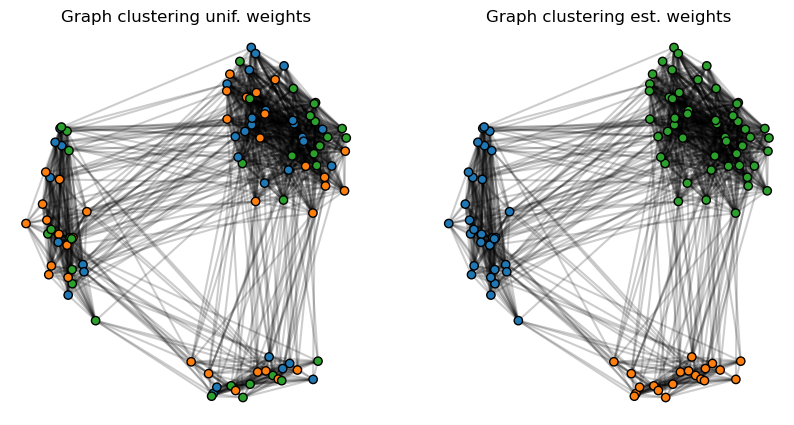

In [5]:
T_unif = ot.gromov_wasserstein(C1, C0, ot.unif(n), ot.unif(3))
label_unif = T_unif.argmax(1)

T_est = ot.gromov_wasserstein(C1, C0, ot.unif(n), a0_est)
label_est = T_est.argmax(1)

pl.figure(3, (10, 5))
pl.clf()
pl.subplot(1, 2, 1)
plot_graph(x1, C1, color=label_unif)
pl.title("Graph clustering unif. weights")
pl.axis("off")
pl.subplot(1, 2, 2)
plot_graph(x1, C1, color=label_est)
pl.title("Graph clustering est. weights")
pl.axis("off")

## Graph compression with GW
Now we optimize both the weights and structure of a small graph that
minimize the GW distance wrt our data graph. This can be seen as graph
compression but can also recover important properties of an SBM such
as its class proportion but also its matrix of probability of links between
classes



Estimated weights :  [0.30768583 0.49706201 0.19525215]
True proportions :  [0.5 0.3 0.2]
C0_est2.shape is (3, 3)


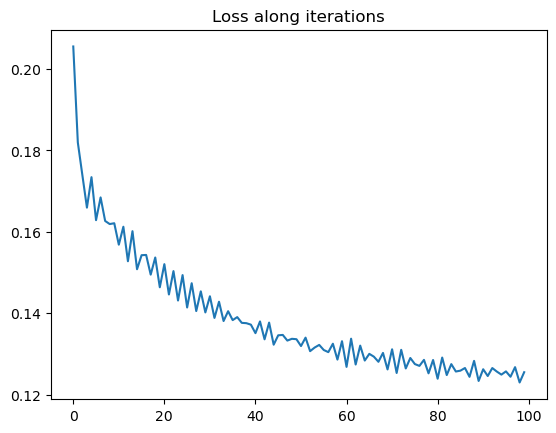

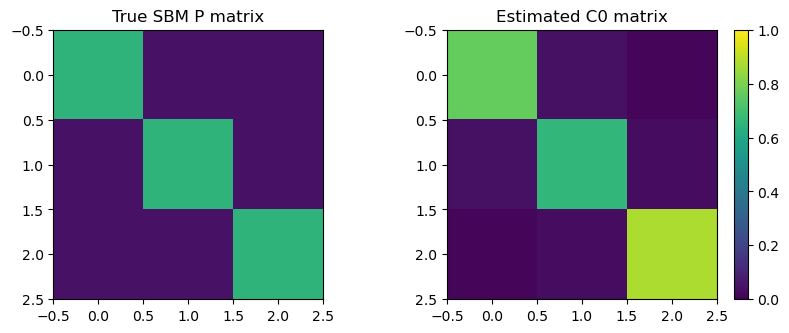

In [46]:
def graph_compession_gw(nb_nodes, C2, a2, nb_iter_max=100, lr=1e-2):
    """ solve min_a GW(C1,C2,a, a2) by gradient descent"""

    # use pyTorch for our data

    C2_torch = torch.tensor(C2)
    a2_torch = torch.tensor(a2)

    a0 = rng.rand(nb_nodes)  # random_init
    a0 /= a0.sum()  # on simplex
    a1_torch = torch.tensor(a0).requires_grad_(True)
    C0 = np.eye(nb_nodes)
    C1_torch = torch.tensor(C0).requires_grad_(True)

    loss_iter = []

    for i in range(nb_iter_max):

        loss = gromov_wasserstein2(C1_torch, C2_torch, a1_torch, a2_torch)

        loss_iter.append(loss.clone().detach().cpu().numpy())
        loss.backward()

        #print("{:03d} | {}".format(i, loss_iter[-1]))

        # performs a step of projected gradient descent
        with torch.no_grad():
            grad = a1_torch.grad
            a1_torch -= grad * lr   # step
            a1_torch.grad.zero_()
            a1_torch.data = ot.utils.proj_simplex(a1_torch)

            grad = C1_torch.grad
            C1_torch -= grad * lr   # step
            C1_torch.grad.zero_()
            C1_torch.data = torch.clamp(C1_torch, 0, 1)

    a1 = a1_torch.clone().detach().cpu().numpy()
    C1 = C1_torch.clone().detach().cpu().numpy()

    return a1, C1, loss_iter


nb_nodes = 3
a0_est2, C0_est2, loss_iter2 = graph_compession_gw(nb_nodes, C1, ot.unif(n),
                                                   nb_iter_max=100, lr=5e-2)

pl.figure(4)
pl.plot(loss_iter2)
pl.title("Loss along iterations")


print("Estimated weights : ", a0_est2)
print("True proportions : ", ratio)

print('C0_est2.shape is', C0_est2.shape)
pl.figure(6, (10, 3.5))
pl.clf()
pl.subplot(1, 2, 1)
pl.imshow(P, vmin=0, vmax=1)
pl.title('True SBM P matrix')
pl.subplot(1, 2, 2)
pl.imshow(C0_est2, vmin=0, vmax=1)
pl.title('Estimated C0 matrix')
pl.colorbar()